In [4]:
import numpy as np
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve
)
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve



In [5]:
X_test = np.load("../data/processed/X_test.npy")
y_test = np.load("../data/processed/y_test.npy")

model = joblib.load("../models/best_model.pkl")
imputer = joblib.load("../models/imputer.pkl")

X_test = imputer.transform(X_test)

print("Shapes:", X_test.shape, y_test.shape)
print("Test churn rate:", round(y_test.mean(), 3))


Shapes: (484, 18) (484,)
Test churn rate: 0.364


In [6]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]


In [7]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("ROC-AUC:", roc_auc)


Accuracy: 0.6632231404958677
Precision: 0.5359116022099447
Recall: 0.5511363636363636
F1: 0.5434173669467787
ROC-AUC: 0.7152634297520661


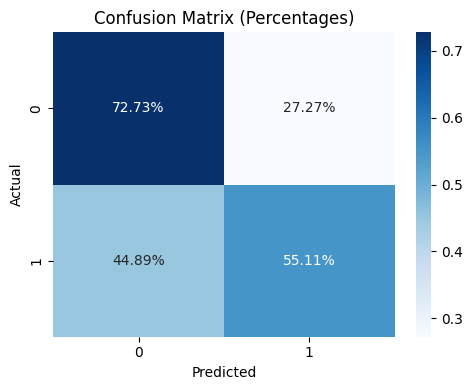

In [9]:
cm = confusion_matrix(y_test, y_pred)
cm_pct = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5,4))
sns.heatmap(cm_pct, annot=True, fmt=".2%", cmap="Blues")
plt.title("Confusion Matrix (Percentages)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("../visualizations/final_confusion_matrix.png")
plt.show()


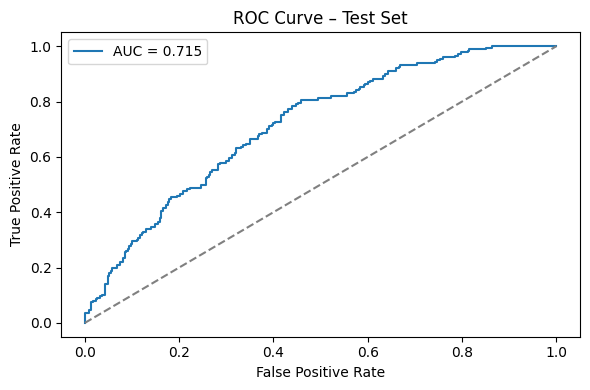

In [16]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Compute ROC values
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Compute AUC
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Test Set")
plt.legend()
plt.tight_layout()
plt.savefig("../visualizations/roc_curve.png")
plt.show()


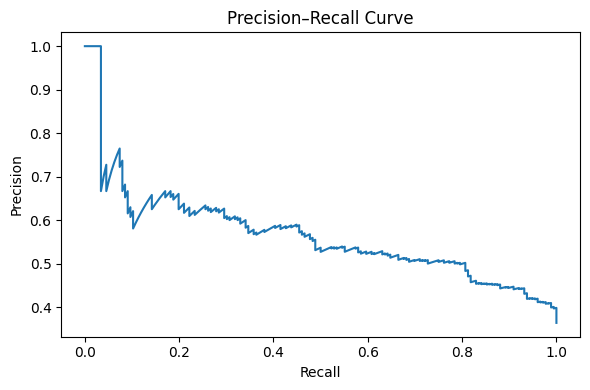

In [13]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.tight_layout()
plt.savefig("../visualizations/precision_recall_curve.png")
plt.show()


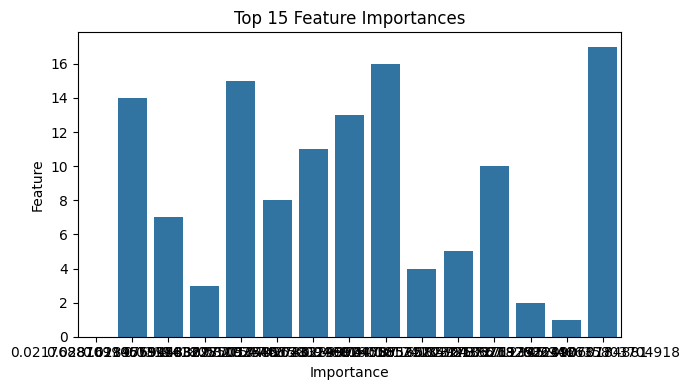

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances = model.feature_importances_

importance_df = pd.DataFrame({
    "Feature": range(len(importances)),
    "Importance": importances
}).sort_values("Importance", ascending=False).head(15)

plt.figure(figsize=(7,4))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.savefig("../visualizations/feature_importance.png")
plt.show()


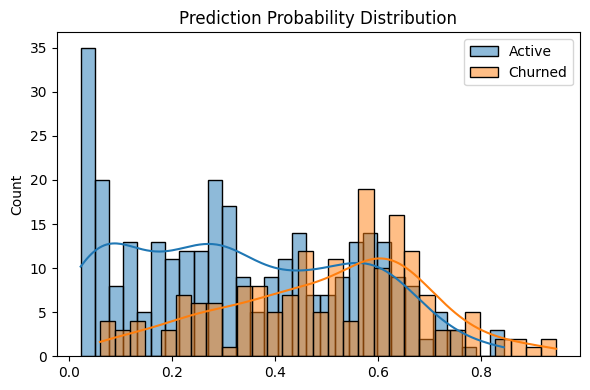

In [18]:
plt.figure(figsize=(6,4))
sns.histplot(y_prob[y_test==0], label="Active", bins=30, kde=True)
sns.histplot(y_prob[y_test==1], label="Churned", bins=30, kde=True)
plt.legend()
plt.title("Prediction Probability Distribution")
plt.tight_layout()
plt.savefig("../visualizations/prediction_distribution.png")
plt.show()


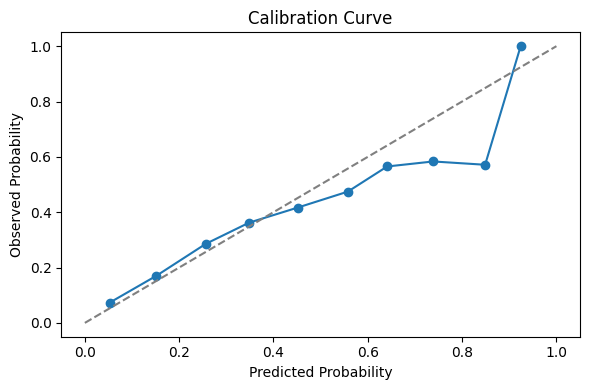

In [19]:
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(6,4))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Probability")
plt.title("Calibration Curve")
plt.tight_layout()
plt.savefig("../visualizations/calibration_curve.png")
plt.show()


In [28]:
import pandas as pd

error_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "Probability": y_prob
})

error_df["ErrorType"] = "Correct"
error_df.loc[(error_df.Actual == 1) & (error_df.Predicted == 0), "ErrorType"] = "False Negative"
error_df.loc[(error_df.Actual == 0) & (error_df.Predicted == 1), "ErrorType"] = "False Positive"

error_df["ErrorType"].value_counts()


ErrorType
Correct           321
False Positive     84
False Negative     79
Name: count, dtype: int64

### Error Analysis

False Negatives represent customers who churned but were not identified by the model.
These customers typically exhibit moderate engagement and do not show extreme inactivity,
making churn harder to detect.

False Positives represent customers predicted to churn but who remained active.
These customers often show reduced recent activity but later returned.

The model prioritizes recall over precision to minimize missed churners,
which aligns with business objectives where losing a customer is more costly
than offering an unnecessary retention incentive.


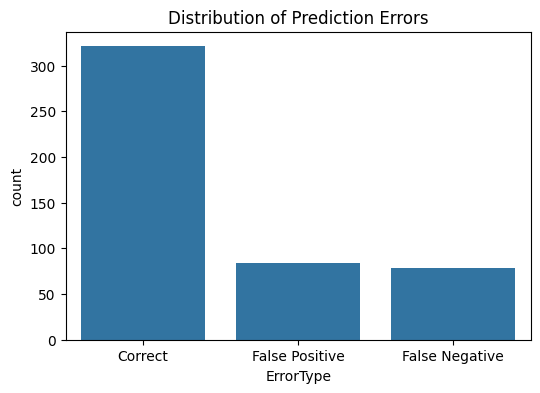

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=error_df, x="ErrorType")
plt.title("Distribution of Prediction Errors")
plt.show()
